In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

In [2]:
class Model(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, num_layers, hidden_size = 100, biDirectional = False):
        super(Model, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        num_classes : 28 = (For full classification)
        hidden_sie : Size of the hidden_state of the LSTM   (// Later BiLSTM)
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
        --------

        """

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.mlp_out_size = mlp_out_size
        self.biDirectional = biDirectional

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        
        self.lstm_layer = LSTM(self.batch_size, self.hidden_size, self.embedding_length, self.biDirectional, self.num_layers)

        if(self.biDirectional):
            self.mlp = MLP(self.hidden_size*2, self.mlp_out_size, self.num_classes)
#             self.FF = nn.Linear(self.hidden_size*2, num_classes)
        else:
            self.mlp = MLP(self.hidden_size, self.mlp_out_size, self.num_classes)
#             self.FF = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, input_sequence):
        input_ = self.word_embeddings(input_sequence)
        out_lstm, final_hidden_state = self.lstm_layer(input_)
        if self.biDirectional:
            final_hidden_state = final_hidden_state.view(self.num_layers, 2, input_.shape[0], self.hidden_size) # num_layer x num_dir x batch x hidden
            final_hidden_state = final_hidden_state[-1]
            final_hidden_state = final_hidden_state.transpose(0,1).reshape(input_.shape[0], self.hidden_size*2)
        else:
            final_hidden_state = final_hidden_state[-1]
        
        mlp_output = self.mlp(final_hidden_state)
#         ff_output = self.FF(mlp_output)
#         print("FF out size: ", ff_output.shape)
        predictions = torch.softmax(mlp_output, dim = -1)
        return predictions

In [3]:
class LSTM(torch.nn.Module):
    """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
        embedding_length : Embeddding dimension of GloVe word embeddings
        --------
    """
    def __init__(self, batch_size, hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(LSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.embedding_length = embedding_length
        self.biDirectional= biDirectional
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm, final_hidden_state

In [4]:
# If want to add extra MLP Layer
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_classes):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
        self.relu = nn.ReLU()
        self.ff_2 = nn.Linear(self.output_dim, self.num_classes)
#         self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
        out_relu = self.relu(out_1)
        out_2 = self.ff_2(out_relu)
#         out_sigmoid = self.sigmoid(out_2)

        return out_2

In [5]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

In [13]:
def train_model(model, optim, train_iter, epoch, batch_size, num_classes):
    total_epoch_loss = 0
    total_epoch_acc = 0
    
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.labels
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size): # One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
#         print(prediction.shape)
#         print(prediction)
#         print(target.shape)
#         print(target)
        loss =  loss_fn(prediction, target)
#         if math.isnan(loss.item()):
#             print(prediction, target)

        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

In [24]:
def eval_model(model, val_iter, batch_size, num_classes):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not batch_size):
                continue
            target = batch.labels
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            # Sanity check
            # print("Test Prediction: ", prediction)
            # Defualt - Cross entropy loss funtion
            loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [25]:
def load_data(batch_size= 16, embedding_length = 100):
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=30)
    LABELS = data.LabelField(batch_first=True, dtype=torch.float)

    train, val, test = data.TabularDataset.splits(
      path='/Users/prakruti/Documents/GoEmotions-classification/data/multi_class_data/', train='train.tsv',
      validation='dev.tsv', test='test.tsv', format='tsv',
      fields=[('text', TEXT), ('labels', LABELS)])
    
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train, val, test), batch_sizes=(batch_size, batch_size, batch_size), sort_key=lambda x: len(x.text), device=0)

    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABELS.build_vocab(train)
    print(LABELS.vocab.__dict__)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter

In [26]:
# def vectorize(x):
#     if x == '':
#         return 5
#     else:
#         x = float(x)
#         return int(x)

In [27]:
batch_size = 32
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_data(batch_size)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'27': 14219, '0': 4130, '4': 2939, '15': 2662, '3': 2470, '1': 2328, '7': 2191, '18': 2086, '10': 2022, '20': 1581, '2': 1567, '17': 1452, '6': 1368, '25': 1326, '9': 1269, '22': 1110, '5': 1087, '26': 1060, '13': 853, '11': 793, '8': 641, '14': 596, '24': 545, '12': 303, '19': 164, '23': 153, '21': 111, '16': 77}), 'itos': ['27', '0', '4', '15', '3', '1', '7', '18', '10', '20', '2', '17', '6', '25', '9', '22', '5', '26', '13', '11', '8', '14', '24', '12', '19', '23', '21', '16'], 'unk_index': None, 'stoi': defaultdict(None, {'27': 0, '0': 1, '4': 2, '15': 3, '3': 4, '1': 5, '7': 6, '18': 7, '10': 8, '20': 9, '2': 10, '17': 11, '6': 12, '25': 13, '9': 14, '22': 15, '5': 16, '26': 17, '13': 18, '11': 19, '8': 20, '14': 21, '24': 22, '12': 23, '19': 24, '23': 25, '21': 26, '16': 27}), 'vectors': None}


In [28]:
# next(iter(train_iter))

In [29]:
# next(iter(test_iter))

In [30]:
# next(iter(valid_iter))

In [32]:
# Cross entropy loss
loss_fn = F.cross_entropy

learning_rate = 2e-4
embedding_length = 100
num_classes = 28
mlp_out_size = 64
weights = word_embeddings
hidden_size = 200
num_layers = 3

model = Model(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, num_layers, hidden_size, biDirectional=False)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [33]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc'])

while(True):
    print("Epoch", epoch)
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size, num_classes)
    val_loss, val_acc = eval_model(model, valid_iter, batch_size, num_classes) 
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), "models/LSTM_BS_32_28C")
    else:
        num_bad_epochs += 1
#     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%') 
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%')
    print("-------------")
    
    training_stats = training_stats.append(
        pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc], index=training_stats.columns), 
        ignore_index=True)
    if num_bad_epochs >= 8:
        break
        
    epoch += 1
    if epoch == 50:
        break

Epoch 0
Epoch: 01
*** Least validation loss
Train Loss: 3.113, Train Acc: 27.72%
Val Loss: 3.099178, Val Acc: 27.56%
-------------
Epoch 1
Epoch: 02
*** Least validation loss
Train Loss: 3.112, Train Acc: 27.80%
Val Loss: 3.099178, Val Acc: 27.56%
-------------
Epoch 2
Epoch: 03
Train Loss: 3.112, Train Acc: 27.80%
Val Loss: 3.099178, Val Acc: 27.56%
-------------
Epoch 3
Epoch: 04
Train Loss: 3.112, Train Acc: 27.80%
Val Loss: 3.099178, Val Acc: 27.56%
-------------
Epoch 4
Epoch: 05
Train Loss: 3.112, Train Acc: 27.80%
Val Loss: 3.099178, Val Acc: 27.56%
-------------
Epoch 5


KeyboardInterrupt: 

In [17]:
training_stats.to_csv('training_stats/LSTM_BS_32_28C.csv')

In [18]:
loaded_model = Model(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights,num_layers, hidden_size, biDirectional=True)
loaded_model.load_state_dict(torch.load('models/LSTM_BS_32_28C'))
loaded_model.eval()

Model(
  (word_embeddings): Embedding(49539, 100)
  (lstm_layer): LSTM(
    (lstm): LSTM(100, 100, num_layers=3, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=64, bias=True)
    (relu): ReLU()
    (ff_2): Linear(in_features=64, out_features=28, bias=True)
  )
)

In [19]:
test_loss, test_acc = eval_model(loaded_model, test_iter, num_classes)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}')

Test Loss: 3.102, Test Acc: 28.14


In [20]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen)

    # print(test_tensor)
    loaded_model.eval()
#     print(test_tensor.shape)
    prediction = loaded_model(test_tensor)
    print("prediction =", prediction)

    out_class = torch.argmax(prediction)
    return out_class

In [21]:
# Groupping Emotion Label:
#     0 - Anger, 1 - Fear, 2- Joy, 
#     3 - Sadness, 4 - Surprise, 5 - Neutral/Ambigous


"""
{'2': 0, Joy
'5': 1,  Neutral 
'0': 2,  Anger
'4': 3,  Surprise
'3': 4,  Sadness
'1': 5}  Fear
"""
# test_sen1 = "I enjoyed it."
test_sen1 = "We need more boards and to create a bit more space for [NAME]. Then we’ll be good." # Neutral
test_sen2 = "Not surprised, damn that sucks. Concussions are awful." # Anger
# test_sen3 = "Are you kidding me!! Really??"
# test_sen3 = "seriously wtf. I want to see how the whole hand went in detail. that was the sickest soulread ever" # Anger
test_sen3 = "Thank you SO much! This is so genuine and so helpful. Thank you so much for your time and your thoughts."
test_sen4 = "I am so happy for you" # Joy
test_sen5 = "I do not know what that is." # Nuetral
test_sen6 = "Are you kidding me!! Really??" # Joy

test_sen = [test_sen1, test_sen2, test_sen3, test_sen4, test_sen5, test_sen6]

for i in range(6):
    print('------------')
    x = test_sentence(test_sen[i])
    print(x)

------------
['we', 'need', 'more', 'boards', 'and', 'to', 'create', 'a', 'bit', 'more', 'space', 'for', '[name].', 'then', 'we’ll', 'be', 'good.']
prediction = tensor([[1.0000e+00, 3.0543e-08, 4.6545e-08, 3.5446e-09, 2.5765e-08, 6.1803e-09,
         6.6318e-09, 1.3667e-08, 2.9194e-09, 2.7421e-10, 3.2225e-10, 8.0342e-09,
         5.5888e-09, 2.9117e-10, 1.0013e-08, 1.6529e-08, 3.5969e-09, 1.5985e-09,
         4.8253e-09, 1.7151e-09, 1.9070e-09, 1.5063e-08, 4.9514e-10, 8.4247e-11,
         1.6194e-08, 3.1296e-09, 2.7033e-09, 1.4516e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
------------
['not', 'surprised,', 'damn', 'that', 'sucks.', 'concussions', 'are', 'awful.']
prediction = tensor([[1.0000e+00, 3.2330e-08, 4.9135e-08, 3.7737e-09, 2.7265e-08, 6.5604e-09,
         7.0411e-09, 1.4491e-08, 3.1164e-09, 2.9387e-10, 3.4498e-10, 8.5203e-09,
         5.9263e-09, 3.1216e-10, 1.0628e-08, 1.7496e-08, 3.8227e-09, 1.7052e-09,
         5.1205e-09, 1.8294e-09, 2.0297e-09, 1.5968e-08, 5.2921

In [2]:
training_stats = pd.read_csv('LSTM_MLP_3L.csv')
training_stats

,Unnamed: 0,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc
0,0,1.0,1.635423,37.073968,1.626468,37.996324
1,1,2.0,1.633184,37.412491,1.628863,37.996324
2,2,3.0,1.628579,38.492539,1.590984,44.264706
3,3,4.0,1.557825,47.925111,1.531470,50.459559
4,4,5.0,1.529384,51.195192,1.526693,51.011029
5,5,6.0,1.506760,53.412859,1.505448,53.051471
6,6,7.0,1.496709,54.334009,1.500994,53.474265
7,7,8.0,1.478637,56.065770,1.493837,54.080882
8,8,9.0,1.469613,57.106669,1.491429,54.301471
9,9,10.0,1.462834,57.838983,1.485382,54.834559


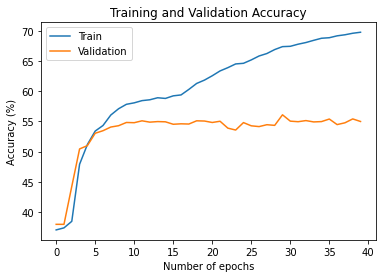

In [3]:
plt.title("Training and Validation Accuracy")
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

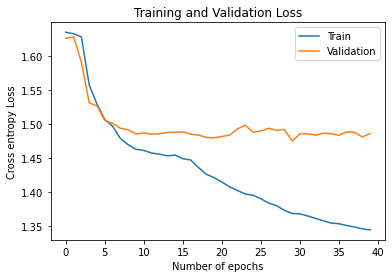

In [4]:
# Training/Validation Loss
plt.title("Training and Validation Loss")
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy Loss")
plt.legend()
plt.show()
